In [1]:
%%capture
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn.functional import relu
from torch.utils.data import Dataset
from torchvision import models
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from tensorboardX import SummaryWriter

# Data Loading

In [ ]:
root_dir = "../../data"
files_list = os.listdir(os.path.join(root_dir, "OTU_2d", "images"))  #, "*.JPG")

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, test_mode=False):
        self.img_dir = img_dir
        self.mask_dir = img_dir.replace("images", "masks")
        self.transform = transform
        self.target_transform = target_transform
        self.test_mode = test_mode
        if self.test_mode:
            self.imgs = self._get_imgs(img_dir)
        else:
            self.imgs, self.masks = self._get_imgs_and_masks(img_dir)

            print(self.masks)

    def _get_imgs_and_masks(self, img_dir):
        imgs = []
        masks = []
        for filename in os.listdir(img_dir):
            if filename.endswith(".JPG"): # and not filename.endswith(".PNG"):
                mask_filename = filename.replace("images", "masks").replace('.JPG', ".PNG")
                #if mask_filename in os.listdir(img_dir):
                imgs.append(filename)
                masks.append(mask_filename)
                    
        # Debugging: Print out the number of images and masks found
        print(f"Found {len(imgs)} images and {len(masks)} masks in {img_dir}. Train/validation mode is on")

        return imgs, masks
    
    def _get_imgs(self, img_dir):
        imgs = []
        for filename in os.listdir(img_dir):
            if filename.endswith(".JPG"):
                imgs.append(filename)
        
        print(f"Found {len(imgs)} images in {img_dir}. Test mode is on")

        return imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.imgs[idx])
        img = Image.open(img_path).convert('L')
        if self.transform:
            img = self.transform(img)
            
        if self.test_mode:
            return img
            
        mask_path = os.path.join(self.mask_dir, self.masks[idx])
        mask = Image.open(mask_path).convert('L')
        #mask = mask.point(lambda p: 1 if p > 0 else 0)
        if self.target_transform:
            mask = self.target_transform(mask) #/np.max(mask)
        return img, mask

In [4]:
import torchvision.transforms as transforms

# Define transforms
transform = transforms.Compose([
    transforms.Pad(14, fill=0, padding_mode='constant'),
    transforms.Resize((256, 256)),  # Corrected from Resized to Resize
    transforms.ToTensor(),
])

transform2 = transforms.Compose([
    transforms.Pad(14, fill=0, padding_mode='constant'),
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Preserve binary values
    transforms.ToTensor(),  # Convert to tensor
    transforms.Lambda(lambda x: (x > 0).float())  # Ensure binary mask (0 or 1)
])


# Create datasets
train_dataset = CustomImageDataset(os.path.join(root_dir, "OTU_2d", "images"), transform=transform, target_transform=transform2)
test_dataset = CustomImageDataset(os.path.join(root_dir, "OTU_2d", "images"), transform=transform, target_transform=transform2, test_mode=True)

Found 1469 images and 1469 masks in ./data\OTU_2d\images. Train/validation mode is on
['1.PNG', '10.PNG', '100.PNG', '1000.PNG', '1001.PNG', '1002.PNG', '1003.PNG', '1004.PNG', '1005.PNG', '1006.PNG', '1007.PNG', '1008.PNG', '1009.PNG', '101.PNG', '1010.PNG', '1011.PNG', '1012.PNG', '1013.PNG', '1014.PNG', '1015.PNG', '1016.PNG', '1017.PNG', '1018.PNG', '1019.PNG', '102.PNG', '1020.PNG', '1021.PNG', '1022.PNG', '1023.PNG', '1024.PNG', '1025.PNG', '1026.PNG', '1027.PNG', '1028.PNG', '1029.PNG', '103.PNG', '1030.PNG', '1031.PNG', '1032.PNG', '1033.PNG', '1034.PNG', '1035.PNG', '1036.PNG', '1037.PNG', '1038.PNG', '1039.PNG', '104.PNG', '1040.PNG', '1041.PNG', '1042.PNG', '1043.PNG', '1044.PNG', '1045.PNG', '1046.PNG', '1047.PNG', '1048.PNG', '1049.PNG', '105.PNG', '1050.PNG', '1051.PNG', '1052.PNG', '1053.PNG', '1054.PNG', '1055.PNG', '1056.PNG', '1057.PNG', '1058.PNG', '1059.PNG', '106.PNG', '1060.PNG', '1061.PNG', '1062.PNG', '1063.PNG', '1064.PNG', '1065.PNG', '1066.PNG', '1067.PNG', '

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Assuming train_dataset is your instance of CustomImageDataset
total_train_samples = len(train_dataset)
train_size = int(0.8 * total_train_samples)  # 80% for training
validation_size = total_train_samples - train_size  # 20% for validation

train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Now create DataLoaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Feature batch shape: torch.Size([8, 1, 256, 256])
Masks batch shape: torch.Size([8, 1, 256, 256])


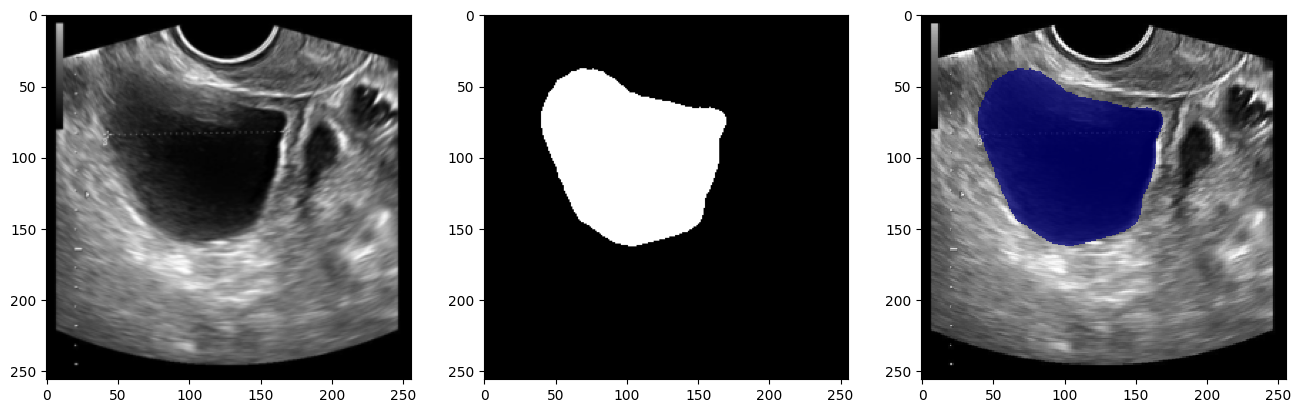

In [6]:
train_features, train_masks = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Masks batch shape: {train_masks.size()}")

img = train_features[0].squeeze()
mask = train_masks[0].squeeze()
img_mask = np.ma.masked_where(mask == 0, mask)

fig, ax = plt.subplots(1,3,figsize = (16,12))

ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(mask, cmap = 'gray')
ax[2].imshow(img, cmap = 'gray', interpolation = 'none')
ax[2].imshow(img_mask, cmap = 'jet', interpolation = 'none', alpha = 0.7)

In [7]:
img.max()

tensor(0.9961)

# EDA

In [8]:
#takes long

def analyze_masks(dataloader):
    mask_presence = []

    for _, masks in dataloader:
        for mask in masks:
            # Assuming binary mask [0, 1]
            object_present = np.any(mask.numpy() > 0)
            mask_presence.append(object_present)

    return mask_presence

mask_presence_train = analyze_masks(train_dataloader)
mask_presence_validation = analyze_masks(validation_dataloader)

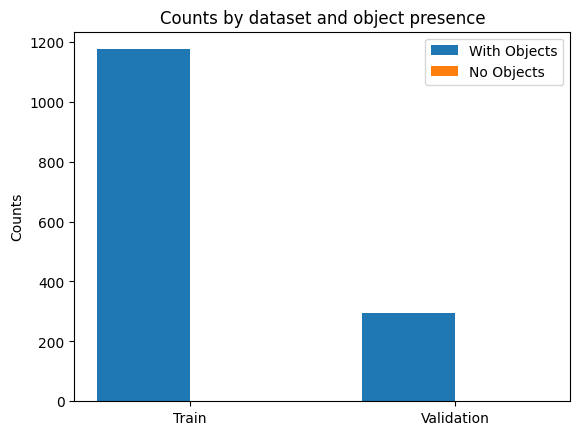

In [9]:
def plot_mask_presence(mask_presence_train, mask_presence_validation):
    train_objects = sum(mask_presence_train)
    train_no_objects = len(mask_presence_train) - train_objects
    validation_objects = sum(mask_presence_validation)
    validation_no_objects = len(mask_presence_validation) - validation_objects

    labels = ['Train', 'Validation']
    objects_counts = [train_objects, validation_objects]
    no_objects_counts = [train_no_objects, validation_no_objects]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, objects_counts, width, label='With Objects')
    rects2 = ax.bar(x + width/2, no_objects_counts, width, label='No Objects')

    ax.set_ylabel('Counts')
    ax.set_title('Counts by dataset and object presence')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

plot_mask_presence(mask_presence_train, mask_presence_validation)

# Data Preprocessing

# Modeling

In [10]:
%%capture
!pip install -U segmentation-models-pytorch
!pip install tqdm

In [11]:
import segmentation_models_pytorch as smp
from tqdm import tqdm

In [12]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move your model to the GPU
model.to(device);

Using device: cuda


In [14]:
#loss = torch.nn.CrossEntropyLoss()

# Assuming class 0 is the background and class 1 is the object
# Adjust weights as necessary based on your dataset
#weights = torch.tensor([0.1, 0.9]).to(device) 
#loss = nn.CrossEntropyLoss(weight=weights)

class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        # Apply sigmoid to the model's output
        inputs = torch.sigmoid(inputs)

        # Select the relevant class (e.g., class '1' for object)
        # Assuming the model outputs two classes (background and object)
        inputs = inputs[:, 1, :, :]  # Shape: [batch_size, height, width]

        # Flatten label and prediction tensors
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)

        intersection = (inputs * targets).sum()
        dice_score = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice_score
"""
dice_loss = DiceLoss()

class CombinedLoss(nn.Module):
    def __init__(self, weight_ce, weight_dice):
        super(CombinedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=weight_ce)
        self.dice_loss = DiceLoss()
        self.weight_dice = weight_dice

    def forward(self, inputs, targets):
        return self.ce_loss(inputs, targets) + self.weight_dice * self.dice_loss(inputs, targets)

# Adjust these weights as necessary
weight_ce = torch.tensor([0.1, 0.9]).to(device)
weight_dice = 0.5  # Example weight, adjust as needed

combined_loss = CombinedLoss(weight_ce, weight_dice)
"""
combined_loss = DiceLoss()

In [15]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
loss_function = combined_loss

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('../../runs/trainer_{}'.format(timestamp))
epoch_number = 0
EPOCHS = 50
best_vloss = 1_000_000.

# Define the training function
# Define the training function
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0

    # Iterate over the training dataset
    for i, data in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch_index + 1}")):
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.squeeze(1).long().to(device)  # Ensure labels are properly formatted

        optimizer.zero_grad()
        outputs = model(inputs)
        loss_value = combined_loss(outputs, labels)
        loss_value.backward()
        optimizer.step()

        running_loss += loss_value.item()
        if i % 100 == 99:
            last_loss = running_loss / 100  # Average loss per batch
            print('  Batch {} Loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.0

    return last_loss

In [ ]:
# Main training and validation loop
for epoch in range(EPOCHS):
    
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train()
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            vinputs, vlabels = vdata
            vinputs = vinputs.float().to(device)  # Shape: [batch_size, channels, height, width]
            vlabels = vlabels.squeeze(1).long().to(device)

            voutputs = model(vinputs)
            vloss = loss_function(voutputs, vlabels)  # Use the combined loss function
            running_vloss += vloss.item()

    avg_vloss = running_vloss / len(validation_dataloader)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    writer.add_scalars('Training vs. Validation Loss',
                       {'Training': avg_loss, 'Validation': avg_vloss},
                       epoch_number + 1)
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '../../checkpoints/deeplabv3/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


Epoch 1:  69%|██████▊   | 101/147 [00:07<00:03, 13.57it/s]

  Batch 100 Loss: 0.7301060742139817


Epoch 1: 100%|██████████| 147/147 [00:11<00:00, 13.07it/s]


LOSS train 0.7301060742139817 valid 0.5181059756794492
EPOCH 2:


Epoch 2:  69%|██████▉   | 102/147 [00:07<00:03, 13.36it/s]

  Batch 100 Loss: 0.4255412757396698


Epoch 2: 100%|██████████| 147/147 [00:10<00:00, 13.61it/s]


LOSS train 0.4255412757396698 valid 0.3343257469099921
EPOCH 3:


Epoch 3:  69%|██████▉   | 102/147 [00:07<00:03, 13.69it/s]

  Batch 100 Loss: 0.2867728078365326


Epoch 3: 100%|██████████| 147/147 [00:10<00:00, 13.55it/s]


LOSS train 0.2867728078365326 valid 0.28162074894518463
EPOCH 4:


Epoch 4:  69%|██████▉   | 102/147 [00:07<00:03, 13.98it/s]

  Batch 100 Loss: 0.24734434723854065


Epoch 4: 100%|██████████| 147/147 [00:10<00:00, 13.60it/s]


LOSS train 0.24734434723854065 valid 0.25820323583242055
EPOCH 5:


Epoch 5:  69%|██████▉   | 102/147 [00:07<00:03, 14.22it/s]

  Batch 100 Loss: 0.2039989447593689


Epoch 5: 100%|██████████| 147/147 [00:10<00:00, 13.88it/s]


LOSS train 0.2039989447593689 valid 0.23974011073241364
EPOCH 6:


Epoch 6:  69%|██████▉   | 102/147 [00:07<00:03, 14.03it/s]

  Batch 100 Loss: 0.18642662584781647


Epoch 6: 100%|██████████| 147/147 [00:10<00:00, 13.74it/s]


LOSS train 0.18642662584781647 valid 0.23066040309699806
EPOCH 7:


Epoch 7:  69%|██████▉   | 102/147 [00:07<00:03, 13.75it/s]

  Batch 100 Loss: 0.17053308308124543


Epoch 7: 100%|██████████| 147/147 [00:10<00:00, 13.73it/s]


LOSS train 0.17053308308124543 valid 0.22446296343932282
EPOCH 8:


Epoch 8:  69%|██████▉   | 102/147 [00:07<00:03, 13.65it/s]

  Batch 100 Loss: 0.1677512699365616


Epoch 8: 100%|██████████| 147/147 [00:10<00:00, 13.65it/s]


LOSS train 0.1677512699365616 valid 0.22174234164727702
EPOCH 9:


Epoch 9:  69%|██████▉   | 102/147 [00:07<00:03, 13.77it/s]

  Batch 100 Loss: 0.15338756024837494


Epoch 9: 100%|██████████| 147/147 [00:10<00:00, 13.63it/s]


LOSS train 0.15338756024837494 valid 0.22063257565369476
EPOCH 10:


Epoch 10:  69%|██████▉   | 102/147 [00:07<00:03, 13.97it/s]

  Batch 100 Loss: 0.13610202193260193


Epoch 10: 100%|██████████| 147/147 [00:10<00:00, 13.70it/s]


LOSS train 0.13610202193260193 valid 0.21016414906527545
EPOCH 11:


Epoch 11:  69%|██████▉   | 102/147 [00:07<00:03, 13.93it/s]

  Batch 100 Loss: 0.13464105606079102


Epoch 11: 100%|██████████| 147/147 [00:10<00:00, 13.73it/s]


LOSS train 0.13464105606079102 valid 0.20243942415392077
EPOCH 12:


Epoch 12:  69%|██████▊   | 101/147 [00:07<00:03, 13.99it/s]

  Batch 100 Loss: 0.1287915116548538


Epoch 12: 100%|██████████| 147/147 [00:10<00:00, 13.70it/s]


LOSS train 0.1287915116548538 valid 0.20066162057825038
EPOCH 13:


Epoch 13:  69%|██████▊   | 101/147 [00:07<00:03, 13.89it/s]

  Batch 100 Loss: 0.12215972781181335


Epoch 13: 100%|██████████| 147/147 [00:10<00:00, 13.63it/s]


LOSS train 0.12215972781181335 valid 0.19653597232457753
EPOCH 14:


Epoch 14:  69%|██████▊   | 101/147 [00:07<00:03, 14.02it/s]

  Batch 100 Loss: 0.11693665325641632


Epoch 14: 100%|██████████| 147/147 [00:10<00:00, 13.72it/s]


LOSS train 0.11693665325641632 valid 0.19250636487393766
EPOCH 15:


Epoch 15:  69%|██████▉   | 102/147 [00:07<00:03, 13.73it/s]

  Batch 100 Loss: 0.11547540307044983


Epoch 15: 100%|██████████| 147/147 [00:10<00:00, 13.64it/s]


LOSS train 0.11547540307044983 valid 0.19773540142420176
EPOCH 16:


Epoch 16:  69%|██████▊   | 101/147 [00:07<00:03, 13.65it/s]

  Batch 100 Loss: 0.1091370314359665


Epoch 16: 100%|██████████| 147/147 [00:10<00:00, 13.70it/s]


LOSS train 0.1091370314359665 valid 0.19101577513926737
EPOCH 17:


Epoch 17:  69%|██████▊   | 101/147 [00:07<00:03, 13.71it/s]

  Batch 100 Loss: 0.10634511113166809


Epoch 17: 100%|██████████| 147/147 [00:10<00:00, 13.71it/s]


LOSS train 0.10634511113166809 valid 0.19411751225187973
EPOCH 18:


Epoch 18:  69%|██████▊   | 101/147 [00:07<00:03, 13.56it/s]

  Batch 100 Loss: 0.10447805821895599


Epoch 18: 100%|██████████| 147/147 [00:10<00:00, 13.69it/s]


LOSS train 0.10447805821895599 valid 0.18686439701028773
EPOCH 19:


Epoch 19:  69%|██████▉   | 102/147 [00:07<00:03, 13.67it/s]

  Batch 100 Loss: 0.10352644264698029


Epoch 19: 100%|██████████| 147/147 [00:10<00:00, 13.64it/s]


LOSS train 0.10352644264698029 valid 0.18818551624143445
EPOCH 20:


Epoch 20:  69%|██████▊   | 101/147 [00:07<00:03, 13.40it/s]

  Batch 100 Loss: 0.10290881216526032


Epoch 20: 100%|██████████| 147/147 [00:10<00:00, 13.74it/s]


LOSS train 0.10290881216526032 valid 0.18480094703468117
EPOCH 21:


Epoch 21:  69%|██████▊   | 101/147 [00:07<00:03, 14.15it/s]

  Batch 100 Loss: 0.09496526002883911


Epoch 21: 100%|██████████| 147/147 [00:10<00:00, 13.66it/s]


LOSS train 0.09496526002883911 valid 0.18165262647577235
EPOCH 22:


Epoch 22:  69%|██████▉   | 102/147 [00:07<00:03, 13.74it/s]

  Batch 100 Loss: 0.09325158298015594


Epoch 22: 100%|██████████| 147/147 [00:10<00:00, 13.72it/s]


LOSS train 0.09325158298015594 valid 0.18001062322307276
EPOCH 23:


Epoch 23:  69%|██████▊   | 101/147 [00:07<00:03, 13.99it/s]

  Batch 100 Loss: 0.09224971354007722


Epoch 23: 100%|██████████| 147/147 [00:10<00:00, 13.71it/s]


LOSS train 0.09224971354007722 valid 0.178577767836081
EPOCH 24:


Epoch 24:  69%|██████▊   | 101/147 [00:07<00:03, 13.85it/s]

  Batch 100 Loss: 0.08772493839263916


Epoch 24: 100%|██████████| 147/147 [00:10<00:00, 13.67it/s]


LOSS train 0.08772493839263916 valid 0.17769917765179197
EPOCH 25:


Epoch 25:  69%|██████▉   | 102/147 [00:07<00:03, 13.81it/s]

  Batch 100 Loss: 0.09294174373149872


Epoch 25: 100%|██████████| 147/147 [00:10<00:00, 13.73it/s]


LOSS train 0.09294174373149872 valid 0.17531178931932193
EPOCH 26:


Epoch 26:  69%|██████▊   | 101/147 [00:07<00:03, 13.63it/s]

  Batch 100 Loss: 0.08528076827526093


Epoch 26: 100%|██████████| 147/147 [00:10<00:00, 13.72it/s]


LOSS train 0.08528076827526093 valid 0.1763486072823808
EPOCH 27:


Epoch 27:  69%|██████▊   | 101/147 [00:07<00:03, 13.82it/s]

  Batch 100 Loss: 0.08212872922420501


Epoch 27: 100%|██████████| 147/147 [00:10<00:00, 13.51it/s]


LOSS train 0.08212872922420501 valid 0.1757946546013291
EPOCH 28:


Epoch 28:  70%|███████   | 103/147 [00:07<00:03, 14.17it/s]

  Batch 100 Loss: 0.08016346395015717


Epoch 28: 100%|██████████| 147/147 [00:10<00:00, 13.86it/s]


LOSS train 0.08016346395015717 valid 0.17269226022668788
EPOCH 29:


Epoch 29:  70%|███████   | 103/147 [00:07<00:03, 14.54it/s]

  Batch 100 Loss: 0.08163344144821166


Epoch 29: 100%|██████████| 147/147 [00:10<00:00, 13.90it/s]


LOSS train 0.08163344144821166 valid 0.17612489977398435
EPOCH 30:


Epoch 30:  69%|██████▉   | 102/147 [00:07<00:03, 14.22it/s]

  Batch 100 Loss: 0.07822407484054565


Epoch 30: 100%|██████████| 147/147 [00:10<00:00, 13.95it/s]


LOSS train 0.07822407484054565 valid 0.17352238216915647
EPOCH 31:


Epoch 31:  69%|██████▉   | 102/147 [00:07<00:03, 13.77it/s]

  Batch 100 Loss: 0.08006249845027924


Epoch 31: 100%|██████████| 147/147 [00:10<00:00, 13.85it/s]


LOSS train 0.08006249845027924 valid 0.17259888391237002
EPOCH 32:


Epoch 32:  70%|███████   | 103/147 [00:07<00:03, 13.98it/s]

  Batch 100 Loss: 0.07925566256046296


Epoch 32: 100%|██████████| 147/147 [00:10<00:00, 13.71it/s]


LOSS train 0.07925566256046296 valid 0.17209967729207631
EPOCH 33:


Epoch 33:  69%|██████▉   | 102/147 [00:07<00:03, 13.99it/s]

  Batch 100 Loss: 0.07362128734588623


Epoch 33: 100%|██████████| 147/147 [00:10<00:00, 13.71it/s]


LOSS train 0.07362128734588623 valid 0.16969474264093348
EPOCH 34:


Epoch 34:  69%|██████▉   | 102/147 [00:07<00:03, 13.87it/s]

  Batch 100 Loss: 0.07560906112194062


Epoch 34: 100%|██████████| 147/147 [00:10<00:00, 13.78it/s]


LOSS train 0.07560906112194062 valid 0.17029035413587415
EPOCH 35:


Epoch 35:  69%|██████▉   | 102/147 [00:07<00:03, 13.89it/s]

  Batch 100 Loss: 0.07192319512367248


Epoch 35: 100%|██████████| 147/147 [00:10<00:00, 13.85it/s]


LOSS train 0.07192319512367248 valid 0.16865006008663694
EPOCH 36:


Epoch 36:  69%|██████▉   | 102/147 [00:07<00:03, 13.83it/s]

  Batch 100 Loss: 0.07499903440475464


Epoch 36: 100%|██████████| 147/147 [00:10<00:00, 13.83it/s]


LOSS train 0.07499903440475464 valid 0.16760783743213964
EPOCH 37:


Epoch 37:  69%|██████▉   | 102/147 [00:07<00:03, 13.69it/s]

  Batch 100 Loss: 0.07105425834655761


Epoch 37: 100%|██████████| 147/147 [00:10<00:00, 13.81it/s]


LOSS train 0.07105425834655761 valid 0.16910374647862203
EPOCH 38:


Epoch 38:  69%|██████▉   | 102/147 [00:07<00:03, 13.84it/s]

  Batch 100 Loss: 0.06982464969158172


Epoch 38: 100%|██████████| 147/147 [00:10<00:00, 13.81it/s]


LOSS train 0.06982464969158172 valid 0.16575422480299667
EPOCH 39:


Epoch 39:  69%|██████▉   | 102/147 [00:07<00:03, 13.73it/s]

  Batch 100 Loss: 0.06983921825885772


Epoch 39: 100%|██████████| 147/147 [00:10<00:00, 13.85it/s]


LOSS train 0.06983921825885772 valid 0.16891269748275345
EPOCH 40:


Epoch 40:  69%|██████▉   | 102/147 [00:07<00:03, 13.83it/s]

  Batch 100 Loss: 0.06827621757984162


Epoch 40: 100%|██████████| 147/147 [00:10<00:00, 13.89it/s]


LOSS train 0.06827621757984162 valid 0.16847048095754674
EPOCH 41:


Epoch 41:  69%|██████▉   | 102/147 [00:07<00:03, 14.30it/s]

  Batch 100 Loss: 0.06994825482368469


Epoch 41: 100%|██████████| 147/147 [00:10<00:00, 13.87it/s]


LOSS train 0.06994825482368469 valid 0.16418330411653262
EPOCH 42:


Epoch 42:  69%|██████▉   | 102/147 [00:07<00:03, 13.72it/s]

  Batch 100 Loss: 0.06907822906970978


Epoch 42: 100%|██████████| 147/147 [00:10<00:00, 13.82it/s]


LOSS train 0.06907822906970978 valid 0.16209274852598035
EPOCH 43:


Epoch 43:  69%|██████▉   | 102/147 [00:07<00:03, 13.64it/s]

  Batch 100 Loss: 0.06442173898220062


Epoch 43: 100%|██████████| 147/147 [00:10<00:00, 13.78it/s]


LOSS train 0.06442173898220062 valid 0.16233752385990038
EPOCH 44:


Epoch 44:  69%|██████▉   | 102/147 [00:07<00:03, 13.79it/s]

  Batch 100 Loss: 0.06926255702972411


Epoch 44: 100%|██████████| 147/147 [00:10<00:00, 13.75it/s]


LOSS train 0.06926255702972411 valid 0.16319234467841484
EPOCH 45:


Epoch 45:  69%|██████▉   | 102/147 [00:07<00:03, 13.87it/s]

  Batch 100 Loss: 0.0662513142824173


Epoch 45: 100%|██████████| 147/147 [00:10<00:00, 13.74it/s]


LOSS train 0.0662513142824173 valid 0.16543339877515226
EPOCH 46:


Epoch 46:  69%|██████▉   | 102/147 [00:07<00:03, 13.72it/s]

  Batch 100 Loss: 0.06308062195777893


Epoch 46: 100%|██████████| 147/147 [00:10<00:00, 13.79it/s]


LOSS train 0.06308062195777893 valid 0.16304185744878408
EPOCH 47:


Epoch 47:  69%|██████▉   | 102/147 [00:07<00:03, 13.89it/s]

  Batch 100 Loss: 0.06209666311740875


Epoch 47: 100%|██████████| 147/147 [00:10<00:00, 13.81it/s]


LOSS train 0.06209666311740875 valid 0.1640135146476127
EPOCH 48:


Epoch 48:  69%|██████▊   | 101/147 [00:07<00:03, 13.86it/s]

  Batch 100 Loss: 0.060957698225975035


Epoch 48: 100%|██████████| 147/147 [00:10<00:00, 13.80it/s]


LOSS train 0.060957698225975035 valid 0.1644375936405079
EPOCH 49:


Epoch 49:  69%|██████▊   | 101/147 [00:07<00:03, 14.21it/s]

  Batch 100 Loss: 0.06234012544155121


Epoch 49: 100%|██████████| 147/147 [00:10<00:00, 13.80it/s]


LOSS train 0.06234012544155121 valid 0.16279220419961052
EPOCH 50:


Epoch 50:  69%|██████▉   | 102/147 [00:07<00:03, 13.90it/s]

  Batch 100 Loss: 0.06178259074687958


Epoch 50: 100%|██████████| 147/147 [00:10<00:00, 13.87it/s]


LOSS train 0.06178259074687958 valid 0.16075887712272438


# Results

## Tensorboard

## Visualizing results

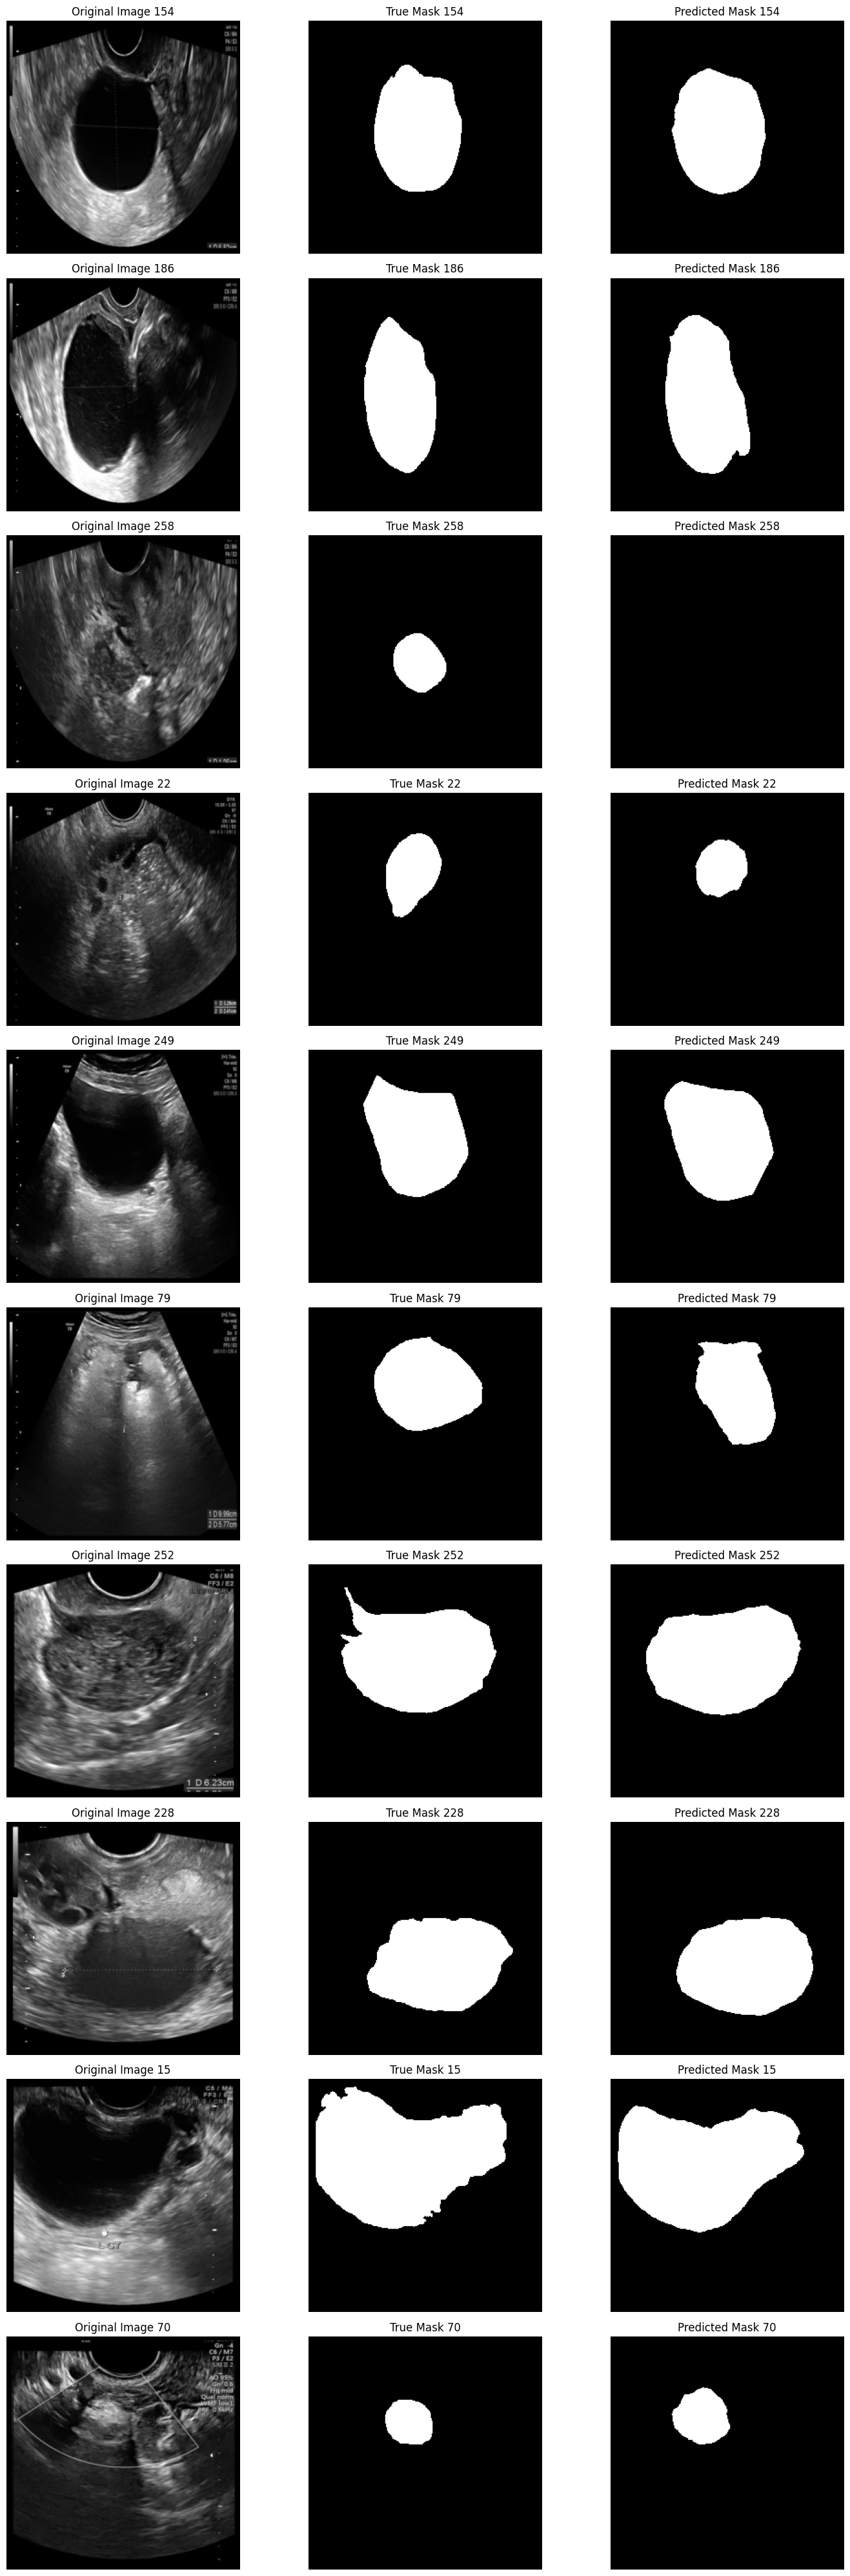

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set the model to evaluation mode
model.eval()

# Randomly select 10 images from the validation dataset
indices = torch.randperm(len(validation_dataset))[:10]

# Create a figure for plotting
fig, axs = plt.subplots(10, 3, figsize=(15, 40))  # 10 rows, 3 columns

with torch.no_grad():
    for i, idx in enumerate(indices):
        # Get the ith sample
        image, true_mask = validation_dataset[idx]

        # Add batch dimension and transfer to the same device as model
        image_batch = image.unsqueeze(0).to(device)

        # Get model prediction
        prediction = model(image_batch)
        predicted_mask = torch.argmax(prediction, dim=1).squeeze(0).cpu()

        # Convert tensors to numpy arrays for plotting
        image_np = image.squeeze().cpu().numpy()
        true_mask_np = true_mask.squeeze().cpu().numpy()
        predicted_mask_np = predicted_mask.numpy()

        # Plot original image
        axs[i, 0].imshow(image_np, cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f'Original Image {idx}')

        # Plot true mask
        axs[i, 1].imshow(true_mask_np, cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f'True Mask {idx}')

        # Plot predicted mask
        axs[i, 2].imshow(predicted_mask_np, cmap='gray')
        axs[i, 2].axis('off')
        axs[i, 2].set_title(f'Predicted Mask {idx}')

plt.tight_layout()
plt.show()

# RLE Encoding and Decoding

In [ ]:
df = pd.read_csv("/kaggle/input/ultrasound-nerve-segmentation/train_masks.csv")

In [ ]:
df

In [ ]:
def rle_encode(mask):
    pixels = mask.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)

In [ ]:
rle_mask = rle_encode(true_mask_np)

In [ ]:
rle_mask

In [ ]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


In [ ]:
# Dimensions of the images (example)
img_shape = (256, 256)  # Replace with actual dimensions

# Decode the first non-NaN RLE string in the DataFrame
for rle_string in df['pixels']:
    if rle_string != 'NaN':
        mask = rle_decode(rle_string, img_shape)
        break

# Encode the mask back to RLE
encoded_rle = rle_encode(mask)


In [ ]:
encoded_rle

# Model Evaluation and Submission

In [ ]:
model.eval()  # Set the model to evaluation mode

predicted_masks = []

with torch.no_grad():
    for test_images in test_dataloader:
        test_images = test_images.to(device)
        outputs = model(test_images)
        
        # Apply sigmoid and threshold to get binary masks
        probs = torch.sigmoid(outputs)
        binary_masks = (probs > 0.5).float()  # Adjust threshold as needed

        predicted_masks.extend(binary_masks.cpu().numpy())

In [ ]:
predicted_masks[0]

In [ ]:
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
encoded_masks = [rle_encode(mask) for mask in predicted_masks]

In [ ]:
encoded_masks

In [ ]:
import pandas as pd

subjects = [i // 120 + 1 for i in range(len(predicted_masks))] 
imgs = [i % 120 + 1 for i in range(len(predicted_masks))]       

# Create DataFrame
df = pd.DataFrame({'subject': subjects, 'img': imgs, 'pixels': encoded_masks})
